authors: [AnandShegde](https://github.com/AnandShegde), [rohit-khoiwal-30](https://github.com/rohit-khoiwal-30),  [Aadesh-1404](https://github.com/Aadesh-1404), [shobro](https://github.com/shobro),[VibhutiBansal-11](https://github.com/VibhutiBansal-11),[haikookhandor](https://github.com/haikookhandor)

In [2]:
# import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

import pkg_resources
import importlib

importlib.reload(pkg_resources)
from functools import partial
from jax.flatten_util import ravel_pytree
from jax import tree_map, tree_leaves
import matplotlib.colors as colors
import numpy as np

In [4]:
try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

tfd = tfp.distributions
tfb = tfp.bijectors
try:
    from flax import linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn
from flax.core.frozen_dict import freeze, unfreeze

try:
    import official.nlp.modeling.layers as nlp_layers
except ModuleNotFoundError:
    %pip install -qq tf-models-official
    import official.nlp.modeling.layers as nlp_layers
try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt blackjax
    import blackjax

try:
    from probml_utils import latexify, savefig
    from probml_utils.blackjax_utils import inference_loop
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig
    from probml_utils.blackjax_utils import inference_loop
try:
    from bijax.advi import ADVI
    from bijax.utils import train_fn
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/patel-zeel/bijax.git
    from bijax.advi import ADVI
    from bijax.utils import train_fn
try:
    import GPy
except:
    %pip install -qq gpy
    import GPy

import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())
from jax.random import PRNGKey as rng_key

In [2]:
# os.environ['LATEXIFY'] = ''
# os.environ['FIG_DIR'] = '.'

In [3]:
latexify(width_scale_factor=2.4, fig_height=2)

 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:25: UserWarning:LATEXIFY environment variable not set, not latexifying


# Dataset Visualization

In [3]:
X, Y = datasets.make_moons(1000, noise=0.20, random_state=6)

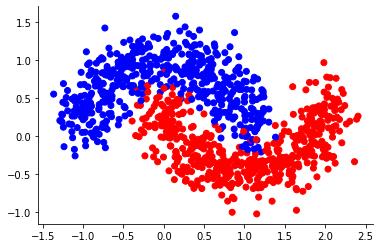

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr")
sns.despine()

In [5]:
X_ood = tfd.MultivariateNormalDiag([-1, -2], [0.2, 0.2]).sample(seed=jax.random.PRNGKey(0), sample_shape=50)

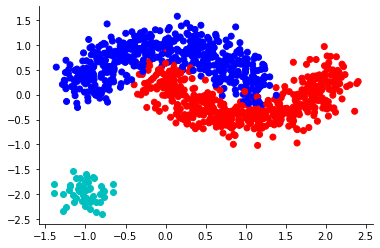

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr")
plt.scatter(*X_ood.T, c="c")
sns.despine()

In [7]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h), jnp.arange(y_min, y_max, h))

In [8]:
xx.shape

(112, 136)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

In [10]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

# Plotting functions

In [11]:
def plot_caliberation_classification(pred_train, pred_test, title, y_train, y_test, legend=0):
    fig, ax1 = plt.subplots(1, 1)
    prob_true_train, prob_pred_train = calibration_curve(y_train, pred_train, n_bins=5)
    prob_true_test, prob_pred_test = calibration_curve(y_test, pred_test)

    disp_train = CalibrationDisplay(prob_true_train, prob_pred_train, pred_train, estimator_name="Train")
    disp_test = CalibrationDisplay(
        prob_true_test,
        prob_pred_test,
        pred_test,
        estimator_name="Test",
    )

    disp_train.plot(ax=ax1)
    disp_test.plot(ax=ax1)
    # handles,labels = ax1.get_legend_handles_labels()
    # labels[0] = "Reference"
    sns.despine(ax=ax1)
    # ax1.legend(handles,labels,loc=legend)
    ax1.get_legend().remove()
    ax1.set_title(title)


plot_caliberation_classification = partial(plot_caliberation_classification, y_train=y_train, y_test=y_test)

In [12]:
def plot_binary_class(
    X_scatters, y_scatters, X_outside, XX1_grid, XX2_grid, grid_preds_mean, titles: str, legend=False, color_bar=False
):
    """
    funtion to binary classificaton outputs

    X: points shape=(n_samples,2)
    y_hat: predictions for X shape=(n_samples,)
    XX1,XX2: grid outputs shape=(n_points,n_points)
    Z: mean of the predictions shape = (n_points,n_points)
    sigma_Z: variance of the predictions shape= (n_points,n_points)
    titles: tuple with title of the two images.
    """

    fig, ax = plt.subplots(1, 1)

    # ax.set_title(titles, fontsize=16)
    CS = ax.contourf(XX1_grid, XX2_grid, grid_preds_mean, cmap="coolwarm", alpha=0.8)
    hs = ax.scatter(X_scatters.T[0], X_scatters.T[1], c=y_scatters, s=4, cmap="bwr")
    ax.scatter(*X_outside.T, c="c", label="OOD", s=4)
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()
        handles_actual, labels_actual = hs.legend_elements()
        handles_actual.extend(handles)
        labels_actual.extend(labels)
        ax.legend(handles_actual, labels_actual)
    if color_bar:
        fig.colorbar(CS)
    sns.despine()

author: [rohit-khoiwal-30](https://github.com/rohit-khoiwal-30)

# Model definition

In [16]:
class cmlp(nn.Module):
    features: list
    activations: list
    dropout_rate: list

    @nn.compact
    def __call__(self, X, deterministic):
        if len(self.activations) != len(self.features) - 1:
            raise Exception(f"Length of activations should be equal to {len(self.features) - 1}")

        if len(self.dropout_rate) != len(self.features) - 1:
            raise Exception(f"Length of dropout_rate should be equal to {len(self.features) - 1}")

        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, name=f"{i}_Dense")(X)
            if i != len(self.features) - 1:
                X = self.activations[i](X)
                X = nn.Dropout(
                    rate=self.dropout_rate[i],
                    deterministic=deterministic,
                    name=f"{i}_Dropout_{self.dropout_rate[i]}",
                )(X)
        return nn.sigmoid(X)

    def loss_fn(self, params, X, y, deterministic=False, rng=jax.random.PRNGKey(0)):
        y_pred = self.apply(params, X, deterministic=False, rngs={"dropout": rng})
        cost0 = jnp.dot(y.T, jnp.log(y_pred + 1e-7))
        cost1 = jnp.dot((1 - y).T, jnp.log(1 - y_pred + 1e-7))
        loss = (cost0 + cost1) / len(X)
        return -loss.squeeze()

# Fit function

In [17]:
def fit(
    model,
    params,
    X,
    y,
    deterministic,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    rng=jax.random.PRNGKey(0),
):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_fn = partial(model.loss_fn, deterministic=deterministic)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    losses = []
    total_epochs = (len(X) // batch_size) * epochs

    carry = {}
    carry["params"] = params
    carry["state"] = opt_state

    @jax.jit
    def one_epoch(carry, rng):
        params = carry["params"]
        opt_state = carry["state"]
        idx = jax.random.choice(rng, jnp.arange(len(X)), shape=(batch_size,), replace=False)
        loss_val, grads = loss_grad_fn(params, X[idx], y[idx], rng=rng)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        carry["params"] = params
        carry["state"] = opt_state

        return carry, loss_val

    carry, losses = jax.lax.scan(one_epoch, carry, jax.random.split(rng, total_epochs))
    return carry["params"], losses

# Single MLP

In [18]:
model = cmlp([8, 16, 16, 8, 1], [nn.relu, nn.relu, nn.relu, nn.relu], [0.03] * 4)

In [19]:
auxs = {
    "X": X_train,
    "y": y_train,
    "deterministic": True,
}

## Train

In [38]:
seed = 0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic=True)
params, loss = fit(model, params, X_train, y_train, True, learning_rate=0.01, epochs=1000, batch_size=64)

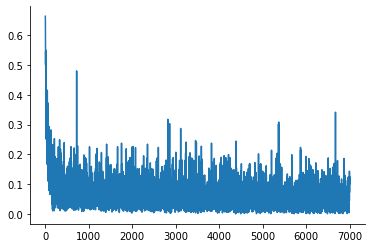

In [39]:
plt.plot(jnp.arange(0, loss.shape[0], 1), loss)
sns.despine()

In [40]:
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


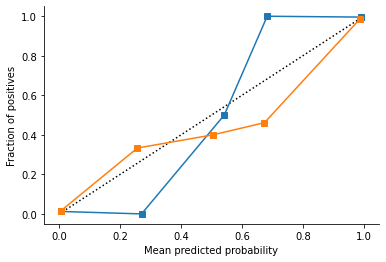

In [42]:
mlp_pred_train = model.apply(params, X_train, deterministic=True).reshape(y_train.shape)
mlp_pred_test = model.apply(params, X_test, deterministic=True).reshape(y_test.shape)
plot_caliberation_classification(mlp_pred_train, mlp_pred_test, title="")
# savefig("figures/MLP_caliberation.pdf")

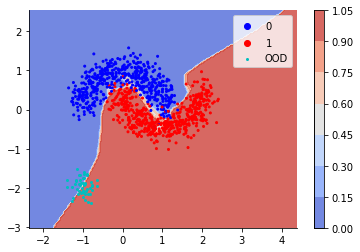

In [43]:
p = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=True).reshape(xx.shape)
var = p * (1 - p).reshape(xx.shape)

plot_binary_class(
    X,
    Y,
    X_ood,
    xx,
    yy,
    p,
    titles=("Probability with Single MLP", "Variance with Single MLP"),
    legend=True,
    color_bar=True,
)
# savefig("figures/mlp_moons.pdf",tight_bbox=False)

author: [VibhutiBansal-11](https://github.com/VibhutiBansal-11)

# Deep Ensemble

In [44]:
params_lst = []
loss_lst = []
for i in range(5):
    params = model.init(jax.random.PRNGKey(i), X, deterministic=True)
    params, loss = fit(model, params, X_train, y_train, True, learning_rate=0.01, epochs=100)
    params_lst.append(params)
    loss_lst.append(loss)

In [45]:
p_de_train_ensemble = []
p_de_test_ensemble = []

for i in range(5):
    params = params_lst[i]
    p = model.apply(params, X_train, deterministic=True)
    p_de_train_ensemble.append(p)
    p = model.apply(params, X_test, deterministic=True)
    p_de_test_ensemble.append(p)
ensemble_pred_train = jnp.array(p_de_train_ensemble).mean(axis=0).reshape(y_train.shape)
ensemble_pred_test = jnp.array(p_de_test_ensemble).mean(axis=0).reshape(y_test.shape)

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


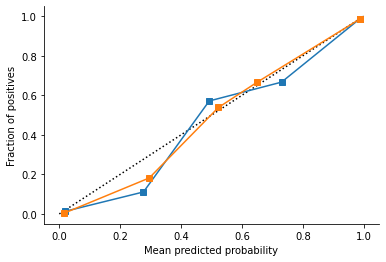

In [46]:
plot_caliberation_classification(ensemble_pred_train, ensemble_pred_test, title="", legend=0)
# savefig("figures/Deep Ensemble caliberation.pdf")

In [47]:
p_grid_ensemble = []

for i in range(5):
    params = params_lst[i]
    p = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=True).reshape(xx.shape)
    p_grid_ensemble.append(p)
ensemble_p_mean = jnp.array(p_grid_ensemble).mean(axis=0)
ensemble_p_sigma = jnp.sqrt(ensemble_p_mean * (1 - ensemble_p_mean))

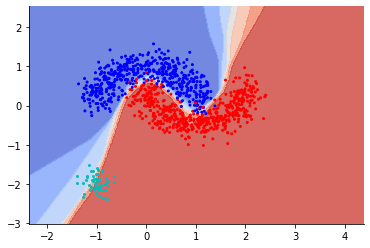

In [48]:
plot_binary_class(
    X,
    Y,
    X_ood,
    xx,
    yy,
    ensemble_p_mean,
    titles=("Probability with Deep ensemble", "Variance with Deep Ensemble"),
    legend=False,
)
# savefig("figures/Deep Ensemble Moons.pdf")

author: [rohit-khoiwal-30](https://github.com/rohit-khoiwal-30)

### MC Dropout

In [49]:
y_stacks = []


@jax.jit
def func(params, i):
    z = model.apply(
        params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)}
    ).reshape(xx.shape)
    return z


y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(50))

In [50]:
mc_pred_mean = jnp.array(y_stacks).mean(axis=0).reshape(xx.shape)
mc_pred_sigma = (jnp.array(y_stacks).std(axis=0)).reshape(yy.shape)

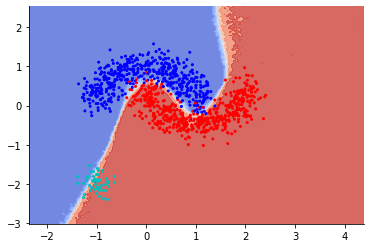

In [51]:
plot_binary_class(X, Y, X_ood, xx, yy, mc_pred_mean, titles=("Probability with MC Droput", "Variance with MC Dropout"))
# savefig("figures/MC Dropout Moons.pdf")

In [52]:
y_stacks_train = []
y_stacks_test = []


def create_apply_func(X_test):
    def func(params, i):
        z = model.apply(params, X_test, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
        return z

    return func


y_stacks_train = jax.vmap(fun=create_apply_func(X_train), in_axes=(None, 0))(params, jnp.arange(50))
y_stacks_test = jax.vmap(fun=create_apply_func(X_test), in_axes=(None, 0))(params, jnp.arange(50))

In [53]:
mc_pred_train = y_stacks_train.mean(axis=0)
mc_pred_test = y_stacks_test.mean(axis=0)

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


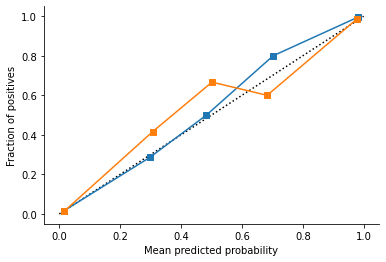

In [54]:
plot_caliberation_classification(mc_pred_train, mc_pred_test, title="")
# savefig("figures/MC_dropout_caliberation.pdf")

author: [haikookhandor](https://github.com/haikookhandor)

# Bootstrap

In [55]:
num_bootstraps = 10
params_list = []
loss_list = []
keys = jax.random.split(jax.random.PRNGKey(0), num_bootstraps)
for i in range(num_bootstraps):
    ids = jax.random.choice(keys[i], jnp.array(range(len(X_train))), (len(X_train),))
    x, y = X_train[ids], y_train[ids]
    params = model.init(jax.random.PRNGKey(i), X_train, deterministic=True)
    params, loss = fit(model, params, x, y, True, batch_size=len(x), learning_rate=0.01, epochs=100)
    params_list.append(params)
    loss_list.append(loss)

In [56]:
bs_train = []
bs_test = []

for i in range(num_bootstraps):
    params = params_list[i]
    b = model.apply(params, X_train, deterministic=True)
    bs_train.append(b)
    b = model.apply(params, X_test, deterministic=True)
    bs_test.append(b)
bootstrap_pred_train = jnp.array(bs_train).mean(axis=0).reshape(y_train.shape)
bootstrap_pred_test = jnp.array(bs_test).mean(axis=0).reshape(y_test.shape)

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


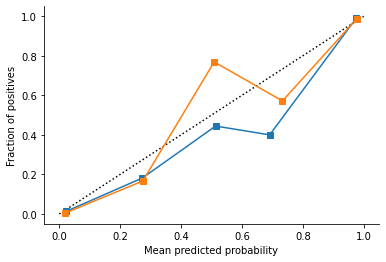

In [57]:
plot_caliberation_classification(bootstrap_pred_train, bootstrap_pred_test, title="")
# savefig("figures/Bootstrap caliberation.pdf")

In [58]:
bootstrap = []

for i in range(num_bootstraps):
    params = params_list[i]
    b = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=True).reshape(xx.shape)
    bootstrap.append(b)
bootstrap_mean = jnp.array(bootstrap).mean(axis=0)
bootstrap_sigma = jnp.sqrt(bootstrap_mean * (1 - bootstrap_mean))

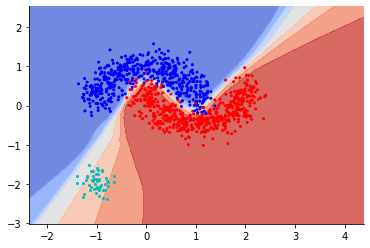

In [59]:
plot_binary_class(X, Y, X_ood, xx, yy, bootstrap_mean, titles=("Probability with Bootstrap", "Variance with Bootstrap"))
# savefig("figures/Bootstrap Moons.pdf")

author: [AnandShegde](https://github.com/AnandShegde)

# NUTS

In [22]:
seed = 0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic=True)

In [27]:
def glorot_prior(param):
    if param.ndim == 1:
        return tfd.Normal(loc=jnp.zeros_like(param), scale=(1.414 / jnp.sqrt(param.shape[0])))
    else:
        return tfd.Normal(loc=jnp.zeros_like(param), scale=(1.414 / jnp.sqrt(param.shape[0] + param.shape[1])))


def one_prior(param):
    if param.ndim == 1:
        return tfd.Normal(loc=jnp.zeros_like(param), scale=1)
    else:
        return tfd.Normal(loc=jnp.zeros_like(param), scale=1)


def set_prior(params, name_of_prior):
    priors = tree_map(name_of_prior, params)
    return priors


def eval_log(prior, param):
    return prior.log_prob(param).sum()


def eval_log_prior(params, priors):
    is_leaf = lambda x: isinstance(x, tfd.Distribution)
    # params_unfreezed = unfreeze(params)
    log_priors = tree_map(eval_log, priors, params, is_leaf=is_leaf)
    return jnp.array(tree_leaves(log_priors)).sum()


def eval_likelihood(params, model, X, Y):
    return tfd.Bernoulli(logits=model.apply(params, X, deterministic=True)).log_prob(Y.reshape((-1, 1))).sum()


def log_joint(params, priors, model, X, Y):
    log_prior = eval_log_prior(params, priors=priors)
    log_likelihood = eval_likelihood(params, model, X, Y)
    return log_prior + log_likelihood
    # return log_likelihood


priors = set_prior(params, one_prior)  # try glorot prior also...

bnn_log_joint_partial = partial(log_joint, model=model, priors=priors, X=X_train, Y=y_train)
bnn_log_joint_partial(params)

DeviceArray(-922.1937, dtype=float32)

In [28]:
def bnn_log_joint(params: dict, X, y, model):
    """
    computes the numerator term of the posterior funtion.

    params: dictionary initalized by model
    X: shape-(n_samples,2) training points
    y: shape-(n_samples,) labels for training points
    model: bnn model
    """

    logits = model.apply(params, X, deterministic=True).ravel()
    # flatten_params gives a list with all the parameters. its dimension will be 1.
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_joint = log_prior + log_likelihood
    return log_joint + log_likelihood


params = model.init(jax.random.PRNGKey(0), X_train, deterministic=True)
bnn_log_joint_partial = partial(bnn_log_joint, X=X, y=Y, model=model)
bnn_log_joint_partial(params)

DeviceArray(-1999.243, dtype=float32)

In [29]:
num_warmup = 3000
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, bnn_log_joint_partial, num_warmup, progress_bar=True)
final_state, kernel, _ = adapt.run(key_warmup, params)

Running window adaptation


In [30]:
num_samples = 3000
states, infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [31]:
from pandas import to_pickle

to_pickle({"states": states, "infos": infos}, "mcmc_moons_good.pkl")

In [32]:
seed = jax.random.PRNGKey(0)


def predict_mcmc(x_test):
    def one_step(carry, state):
        params_cur = state.position
        # samples = tfd.Bernoulli(probs=model.apply(params_cur,x_test,deterministic=True)).sample(seed=seed)
        probs = model.apply(params_cur, x_test, deterministic=True)
        return carry, probs

    _, y_stacks = jax.lax.scan(one_step, None, states)
    y_stacks = y_stacks >= 0.5
    mean = y_stacks.mean(axis=0)
    std_dev = y_stacks.std(axis=0)
    return mean, std_dev


mcmc_pred_mean, mcmc_pred_sigma = predict_mcmc(jnp.c_[xx.ravel(), yy.ravel()])
mcmc_pred_mean, mcmc_pred_sigma = mcmc_pred_mean.reshape(xx.shape), mcmc_pred_sigma.reshape(xx.shape)

 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:84: UserWarning:set FIG_DIR environment variable to save figures


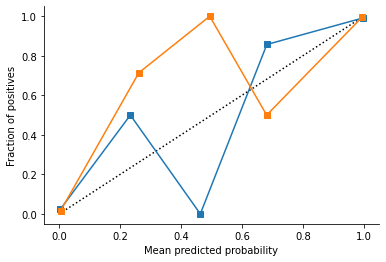

In [33]:
mcmc_pred_train, _ = predict_mcmc(X_train)
mcmc_pred_test, _ = predict_mcmc(X_test)
plot_caliberation_classification(mcmc_pred_train, mcmc_pred_test, title="")
# savefig("figures/MCMC_caliberation_glorot_.pdf")

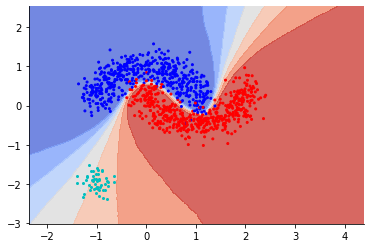

In [34]:
titles_mcmc = ("Mean of Predictions of NUTS", "Variance of Predictions of NUTS")
plot_binary_class(
    X_scatters=X,
    y_scatters=Y,
    XX1_grid=xx,
    XX2_grid=yy,
    grid_preds_mean=mcmc_pred_mean,
    X_outside=X_ood,
    titles=titles_mcmc,
)
# savefig("figures/BNN using MCMC.pdf")
plt.show()

author: [Aadesh-1404](https://github.com/Aadesh-1404)

# GP


Name : gp_classification
Objective : 109.74521506042834
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |        
-109.74521506042834


Optimization restart 1/5, f = 57.934888758665295
Optimization restart 2/5, f = 76.65906248032223
Optimization restart 3/5, f = 87.87882199455757
Optimization restart 4/5, f = 90.42719594319007
Optimization restart 5/5, f = 73.69441627879621

Name : gp_classification
Objective : 77.00501290046213
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  13.753804831925242  |      +ve      |        
  rbf.lengthscale     |  0.7116832623066411  |      +ve      |        


 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


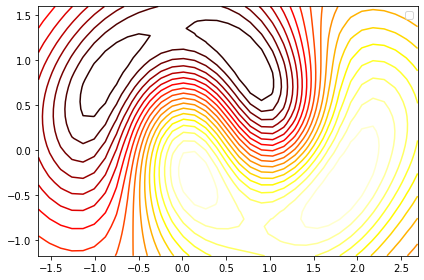

In [65]:
model = GPy.models.GPClassification(np.array(X_train), np.array(y_train.reshape(-1, 1)))
print(model)
print(model.log_likelihood())
model.optimize(messages=True)
model.optimize_restarts(num_restarts=5)
print(model)
model.plot_f()
probability_gp, na = model.predict(jnp.c_[xx.ravel(), yy.ravel()])

In [65]:
probability_gp = probability_gp.reshape(xx.shape)

 /home/anand/Desktop/ML/probml-utils/probml_utils/plotting.py:80: UserWarning:set FIG_DIR environment variable to save figures


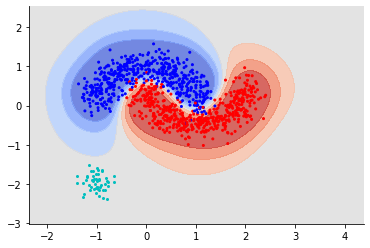

In [66]:
plot_binary_class(X, Y, X_ood, xx, yy, probability_gp, titles=("Probability with GP", "Variance with GP"))
# savefig("figures/GP moons.pdf")

 /home/anand/Desktop/ML/probml-utils/probml_utils/plotting.py:80: UserWarning:set FIG_DIR environment variable to save figures


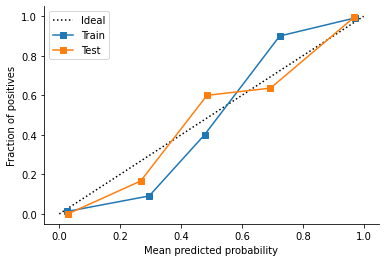

In [67]:
gp_pred_train, na = model.predict(X_train)
gp_pred_test, na = model.predict(X_test)
plot_caliberation_classification(gp_pred_train, gp_pred_test, title="")
# savefig("figures/GP_caliberation.pdf")

# SNGP

In [71]:
class DeepResNet(tf.keras.Model):
    """Defines a multi-layer residual network."""

    def __init__(self, num_classes, num_layers=3, num_hidden=128, dropout_rate=0.1, **classifier_kwargs):
        super().__init__()
        # Defines class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        # Defines the hidden layers.
        self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

        # Defines the output layer.
        self.classifier = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Projects the 2d input data to high dimension.
        hidden = self.input_layer(inputs)

        # Computes the resnet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            hidden += resid

        return self.classifier(hidden)

    def make_dense_layer(self):
        """Uses the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu")

    def make_output_layer(self, num_classes):
        """Uses the Dense layer as the output layer."""
        return tf.keras.layers.Dense(num_classes, **self.classifier_kwargs)

In [72]:
class DeepResNetSNGP(DeepResNet):
    def __init__(self, spec_norm_bound=0.9, **kwargs):
        self.spec_norm_bound = spec_norm_bound
        super().__init__(**kwargs)

    def make_dense_layer(self):
        """Applies spectral normalization to the hidden layer."""
        dense_layer = super().make_dense_layer()
        return nlp_layers.SpectralNormalization(dense_layer, norm_multiplier=self.spec_norm_bound)

    def make_output_layer(self, num_classes):
        """Uses Gaussian process as the output layer."""
        return nlp_layers.RandomFeatureGaussianProcess(num_classes, gp_cov_momentum=-1, **self.classifier_kwargs)

    def call(self, inputs, training=False, return_covmat=False):
        # Gets logits and covariance matrix from GP layer.
        logits, covmat = super().call(inputs)

        # Returns only logits during training.
        if not training and return_covmat:
            return logits, covmat

        return logits

In [73]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.classifier.reset_covariance_matrix()

In [74]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())

        return super().fit(*args, **kwargs)

In [75]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.0):
    logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(logits, covmat, mean_field_factor=lambda_param)

    return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [76]:
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_N_GRID = 100

In [78]:
def train_and_test_sngp(X_train, X_test):
    sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

    sngp_model.compile(**train_config)
    sngp_model.fit(X_train, np.array(y_train), verbose=0, **fit_config)

    sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
    sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

    return sngp_model, sngp_probs

In [79]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = (tf.keras.metrics.SparseCategoricalAccuracy(),)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
fit_config = dict(batch_size=128, epochs=1000)

2022-07-27 00:04:01.537787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 00:04:01.537867: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [81]:
sngp_model, sngp_probs = train_and_test_sngp(np.array(X_train), np.array(X_test))

In [ ]:
sngp_std = np.sqrt(sngp_probs * (1 - sngp_probs))

In [ ]:
sngp_logits, sngp_covmat = sngp_model(np.c_[xx.ravel(), yy.ravel()], return_covmat=True)
sngp_grid_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

In [ ]:
sngp_grid_probs = 1 - np.array(sngp_grid_probs).reshape(xx.shape)

In [ ]:
plot_binary_class(X, Y, X_ood, xx, yy, sngp_grid_probs, titles=("Probability with GP", "Variance with GP"))

# savefig("figures/SNGP Moons.pdf")

/home/anand/Desktop/ML/probml-utils/probml_utils/plotting.py:70: UserWarning: renaming ./figures/SNGP Moons.pdf to ./figures/SNGP Moons_latexified.pdf because LATEXIFY is True
  f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",


saving image to ./figures/SNGP Moons_latexified.pdf
Figure size: [2.5 2. ]


In [ ]:
sngp_pred_train = train_and_test_sngp(np.array(X_train), np.array(X_train))

In [ ]:
sngp_pred_train_actual = 1 - sngp_pred_train[1]
sngp_probs = 1 - sngp_probs

In [ ]:
plot_caliberation_classification(jnp.array(sngp_pred_train_actual), jnp.array(sngp_probs), title="")
# savefig("figures/SNGP_caliberation.pdf")

saving image to ./figures/SNGP_caliberation_latexified.pdf
Figure size: [2.5 2. ]


/home/anand/Desktop/ML/probml-utils/probml_utils/plotting.py:70: UserWarning: renaming ./figures/SNGP_caliberation.pdf to ./figures/SNGP_caliberation_latexified.pdf because LATEXIFY is True
  f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",


author: [shobro](https://github.com/shobro)

# VI

In [17]:
class MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for num_features in self.layers[:-1]:
            x = nn.relu(nn.Dense(num_features)(x))
        x = nn.Dense(self.layers[-1])(x)
        return x.ravel()


mlp = MLP([8, 16, 16, 8, 1])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

In [19]:
seed = jax.random.PRNGKey(45)
frozen_params = mlp.init(seed, X_train)
params = unfreeze(frozen_params)

In [20]:
prior = jax.tree_map(
    lambda param: tfd.Independent(
        tfd.Normal(loc=jnp.zeros(param.shape), scale=jnp.ones(param.shape)),
        reinterpreted_batch_ndims=len(param.shape),
    ),
    params,
)

bijector = jax.tree_map(lambda param: tfb.Identity(), params)


def get_log_likelihood(latent_sample, outputs, inputs, **kwargs):
    frozen_params = freeze(latent_sample)
    logit = mlp.apply(frozen_params, inputs["X"])
    # def sigmoid(x, scale=100):
    #     return 0.5 * (jnp.tanh(x * scale / 2) + 1)
    # prob = sigmoid(logit)
    return tfd.Bernoulli(logits=logit).log_prob(outputs).sum()


model = ADVI(prior, bijector, get_log_likelihood, vi_type="mean_field")

In [21]:
params = model.init(jax.random.PRNGKey(8))
mean = params["posterior"].mean()
params["posterior"] = tfd.MultivariateNormalDiag(
    loc=mean,
    scale_diag=jax.random.normal(jax.random.PRNGKey(3), shape=(len(mean),)) - 10,
)

In [22]:
tx = optax.adam(learning_rate=0.01)
seed2 = jax.random.PRNGKey(100)

loss_fn = partial(model.loss_fn, inputs={"X": X_train}, outputs=y_train, full_data_size=len(y_train), n_samples=100)
results = train_fn(loss_fn, params, optimizer=tx, n_epochs=3000, seed=seed2, return_args={"losses"})

In [23]:
def predict_sample(data):
    posterior = model.apply(results["params"])
    seed = jax.random.PRNGKey(4)
    weights = posterior.sample(seed, sample_shape=(100,))

    def draw_sample(weights):
        logit = mlp.apply(freeze(weights), data)
        y_pred = nn.sigmoid(logit)
        return y_pred

    y_pred = jax.vmap(draw_sample)(weights)
    return y_pred


mean = predict_sample(X).mean(axis=0)
sigma = predict_sample(X).std(axis=0)
y_hat = (mean >= 0.5).astype(int)


brier_score_loss(Y, y_hat)

0.028

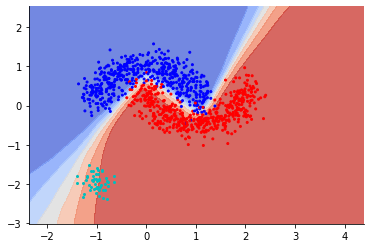

In [24]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h), jnp.arange(y_min, y_max, h))

Z = predict_sample(jnp.c_[xx.ravel(), yy.ravel()]).mean(axis=0)
sigma = predict_sample(jnp.c_[xx.ravel(), yy.ravel()]).std(axis=0)
Z = Z.reshape(xx.shape)
ax = plot_binary_class(
    X_scatters=X, y_scatters=Y, X_outside=X_ood, XX1_grid=xx, XX2_grid=yy, grid_preds_mean=Z, titles="VI"
)
# savefig("MLP_VI.pdf")

 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:84: UserWarning:set FIG_DIR environment variable to save figures


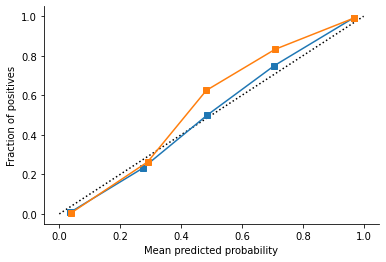

In [26]:
Z_train = predict_sample(X_train).mean(axis=0)
Z_test = predict_sample(X_test).mean(axis=0)


plot_caliberation_classification(Z_train, Z_test, "")
# savefig("Calibration_VI.pdf")